# DC2 Data Access with the Gen-2 Butler

<br>Owner: **Johann Cohen-Tanugi** (@johannct) based on work by **Daniel Perrefort** ([@djperrefort](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@djperrefort))
<br>Last Verified to Run: **2020-11-17**
<br>Verified Stack Release: **w2020_48**

## Core Concepts

This notebook provides a hands-on overview of how to interact with the Gen-2 `Butler` (it should be updated for Gen-3, once available). The `Butler` provides a way to access information using a uniform interface without needing to keep track of how the information is internally stored or organized. Data access with `Butler` has three levels you need to be aware of:

1. Each instantiated `Butler` object provides access to a collection of datasets called a **repository**. Each repository is defined by Butler using the local file directory where the data is stored.
2. Each data set in a **repository** is assigned a unique name called a **type**. These types are strings that describe the data set and should not be confused with an "object type" as defined by Python.
3. Individual entries in a data set are identified using a unique **data identifier**, which is a dictionary who's allowed keys and values depend on the data set you are working with.

## Learning Objectives:

This notebook demonstrates how to use the Gen-2 `Butler` object from the DM stack to access and manipulate data. After finishing this notebook, users will know how to:

1. Load and access a data repository using `Butler`
2. Select subsets of data and convert data into familiar data structures
3. Use `Butler` to access coordinate information and cutout postage stamps
4. Use `Butler` to access a skymap

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os

import lsst.afw.display as afwDisplay
from lsst.daf.persistence import Butler
import lsst.geom
from lsst.geom import SpherePoint, Angle

%matplotlib inline

In [4]:
dc2_version='2.2i_dr6_wfd'
try:
    #if you are on a jupyterLab session at CC, it is necessary to force the env variable to 'in2p3'
    os.environ["DESC_GCR_SITE"]='in2p3'
    import desc_dc2_dm_data
    butler=desc_dc2_dm_data.get_butler(dc2_version)
    repo=desc_dc2_dm_data.REPOS[dc2_version]
except ImportError:
    %pip install git+https://github.com/LSSTDESC/desc-dc2-dm-data
    import desc_dc2_dm_data
    butler=desc_dc2_dm_data.get_butler(dc2_version)
    repo=desc_dc2_dm_data.REPOS[dc2_version]
except ValueError:
#at NERSC
#repo = ''/global/cfs/cdirs/lsst/production/DC2_ImSim/Run2.2i/desc_dm_drp/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1''
#at CC
    repo = '/sps/lssttest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1/'
    butler = Butler(repo)

/pbs/home/t/tanugi/.local/lib/python3.7/site-packages/desc-dc2-dm-data/desc_dc2_dm_data/site.py:28: UserWarning: Site determined from env variable DESC_GCR_SITE = in2p3, which differs from node name 483db08967fa
  _DESC_SITE_ENV, site_from_env, site_from_socket


## Loading Data

To start we instantiate a `Butler` object by providing it with the directory of the **repository** we want to access. Next, we load a **type** of dataset and select data from a single **data identifier**. For this demonstration we consider the `deepCoadd_ref` dataset, which contains tables of information concerning coadded images used in the differencing image pipeline. The id values for this data set include two required values: `tract` and `patch` which denote sections of the sky.


In [5]:
# We choose an "arbitrary" tract and patch. 
# Want to figure out how we found this tract and patch? Check out the notebook on Exploring_A_Data_Repo.ipynb
# should contain a cluster at z=0.66 M=1.5e15
tract_id=4024
patch_id='3,4'
data_id = {'tract': tract_id, 'patch': patch_id}
dataset_type = 'deepCoadd_ref'

# We can check that the data exists before we try to read it
data_exists = butler.datasetExists(datasetType=dataset_type, dataId=data_id)
print('Data exists for ID:', data_exists)

data_entry = butler.get(dataset_type, dataId=data_id)
data_entry


Data exists for ID: True


<class 'lsst.afw.table.SourceCatalog'>
        id             coord_ra      ... merge_measurement_g merge_measurement_u
                         rad         ...                                        
----------------- ------------------ ... ------------------- -------------------
17698168657412097 0.9400645182194894 ...               False               False
17698168657412098 0.9399546695593748 ...               False               False
17698168657412099 0.9398896834055974 ...               False               False
17698168657412100 0.9395824759022172 ...               False               False
17698168657412101 0.9394808587442266 ...               False               False
17698168657412102 0.9393426101343095 ...               False               False
17698168657412103  0.938885348533501 ...               False               False
17698168657412104 0.9388038216542227 ...               False               False
17698168657412105 0.9386454911706492 ...               False          

The data table returned above is formatted as a `SourceCatalog` object, which is essentially a collection of `numpy` arrays. We can see this when we index a particular column. 

In [6]:
print(type(data_entry['merge_measurement_i']))

<class 'numpy.ndarray'>


`SourceCatalog` objects have their own set of methods for table manipulations (sorting, appending rows, etc.). However, we can also work with the data in a more familiar format, such as an astropy `Table` or a pandas `DataFrame`. 

In [7]:
data_frame = data_entry.asAstropy().to_pandas()
data_frame.head()


,id,coord_ra,coord_dec,parent,merge_footprint_i,merge_footprint_r,merge_footprint_z,merge_footprint_y,merge_footprint_g,merge_footprint_u,...,slot_ModelFlux_initial_flag_apCorr,base_ClassificationExtendedness_value,base_ClassificationExtendedness_flag,base_FootprintArea_value,merge_measurement_i,merge_measurement_r,merge_measurement_z,merge_measurement_y,merge_measurement_g,merge_measurement_u
0,17698168657412097,0.940065,-0.608270,0,True,True,True,True,True,True,...,False,NaN,True,2955,True,False,False,False,False,False
1,17698168657412098,0.939955,-0.608294,0,True,True,False,False,False,False,...,False,NaN,True,100,True,False,False,False,False,False
2,17698168657412099,0.939890,-0.608294,0,True,True,True,False,True,False,...,False,NaN,True,179,True,False,False,False,False,False
3,17698168657412100,0.939582,-0.608294,0,True,True,True,True,True,True,...,False,NaN,True,698,True,False,False,False,False,False
4,17698168657412101,0.939481,-0.608292,0,True,True,True,True,True,True,...,False,NaN,True,486,True,False,False,False,False,False


It is important to note that `Butler` objects do not always return tabular data. We will see an example of this later when we load and parse image data.

## Selecting Subsets of Data

In practice, you may not know the format of the data identifier for a given data set. In this case, the `getKeys()` method can be used to determine the key values expected in a **data identifier**. 

In [8]:
data_id_format = butler.getKeys(dataset_type)
print('Expected data id format:', data_id_format)


Expected data id format: {'tract': <class 'int'>, 'patch': <class 'str'>}


It is important to note that if you specify a key that is not part of the data **type**, the `Butler` will silently ignore it. This can be misleading. For example, in the previous example we read in a table that has a column of booleans named `merge_footprint_i`. If you specify `merge_footprint_i: True` in the dataID and rerun the example, `Butler` will ignore the extra key silently. As a result, you might expect the returned table to only include values where `merge_footprint_i` is `True`, but that isn't what happens. 

Here is an example of the correct way to select data from the returned table:


In [9]:
# An example of what not to do!!
#
# new_data_id = {'tract': 0, 'patch': '1,1', 'merge_footprint_i': True}
# merged_i_data = butler.get(dataset_type, dataId=new_data_id)
# assert merged_i_data['merge_measurement_i'].all()

# Do this instead...
new_data_id = {'tract': tract_id, 'patch': patch_id}
merged_i_data = butler.get(dataset_type, dataId=new_data_id)
merged_i_data = merged_i_data[merged_i_data['merge_measurement_i']].copy(True)

# Check that the returned table does in fact have only entries where
# merge_footprint_i is True
print(merged_i_data['merge_measurement_i'].all())


True


**Important:**  Note the use of `copy` above which is required to create an array that is contiguous in memory (yay!)

You can also select all complete dataIds for a dataset type that match a partial (or empty) dataId. For example, the below cell iterates over all possible ids and checks if the corresponding file exists.


In [10]:
subset = butler.subset(dataset_type, dataId=data_id)
id_list = [dr.dataId for dr in subset if dr.datasetExists()]
print(f'Available Ids:\n {id_list}')


Available Ids:
 [DataId(initialdata={'tract': 4024, 'patch': '3,4'}, tag=set())]


## Creating Postage Stamps

When dealing with image data, we can use `Butler` to generate postage stamps at a given set of coordinates. For this example, we consider the `deepCoadd` data set, which has one extra key value than the previous example.

In [11]:
coadd_type = 'deepCoadd_calexp'
butler.getKeys(coadd_type)


{'filter': str, 'tract': int, 'patch': str}

In order to generate a postage stamp, we need to define the center and size of the cutout. First, we pick an RA and Dec from our previous example.

In [12]:
# Find indices of all targets with a flux between 100 and 500 as follows
# np.where((merged_i_data['base_PsfFlux_flux'] > 100) & (merged_i_data['base_PsfFlux_flux'] < 500))

# Pick an RA and Dec
i = 1000
ra =  np.degrees(merged_i_data['coord_ra'][i])
dec = np.degrees(merged_i_data['coord_dec'][i])


Next we plot our cutout.

In [13]:
# Retrieve the image using butler
coadd_id = {'tract': tract_id, 'patch': patch_id, 'filter': 'i'}
image = butler.get(coadd_type, dataId=coadd_id)

# Define the center and size of our cutout
radec = SpherePoint(ra, dec, lsst.geom.degrees)
cutout_size = 500
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)

# Cutout and optionally save the postage stamp to file
postage_stamp = image.getCutout(radec, cutout_extent)
# postage_stamp.writeFits(<output_filename>)


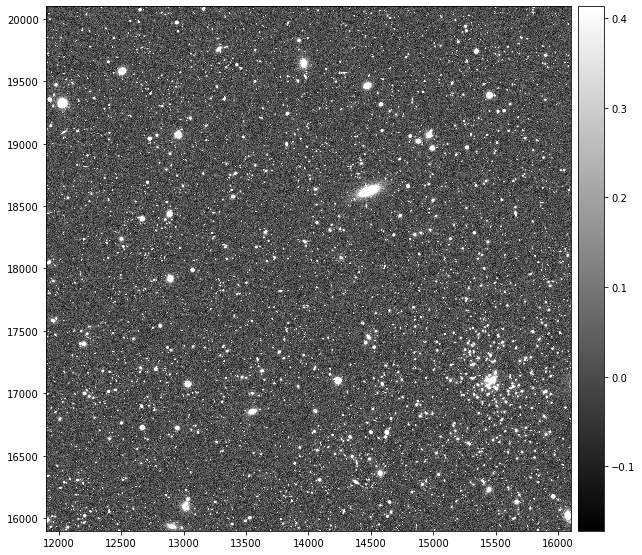

In [14]:
fig = plt.figure(figsize=(10,10))
display = afwDisplay.Display(frame=1, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(image.getMaskedImage().getImage())


Since the postage stamp was generated using `Butler`, it is represented as an `afwImage` object. This is a data type from the DM stack that is used to represent images. Since it is a DM object, we choose to plot it using the DM `afwDisplay` module.

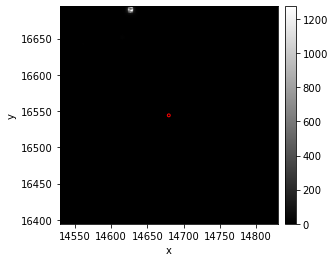

In [15]:
cutout_size = 300
cutout_extent = lsst.geom.ExtentI(cutout_size, cutout_size)
postage_stamp = image.getCutout(radec, cutout_extent)
xy = postage_stamp.getWcs().skyToPixel(radec)

display = afwDisplay.Display(frame=2, backend='matplotlib')
display.mtv(postage_stamp.getMaskedImage().getImage())
display.scale("linear", "zscale")
display.dot('o', xy.getX(), xy.getY(), ctype='red')
display.show_colorbar()


plt.xlabel('x')
plt.ylabel('y')
plt.show()


Note that the cutout image is aware of the masks and pixel values of the original image. This is why the axis labels in the above cutout are so large. We also note that the orientation of the postage stamp is in the x, y orientation of the original coadded image.


## Creating an RGB picture of a coadd patch
A nice and simple interface is also available to create pretty pictures of patch areas (stolen from D. Boutigny). We are using the same patch as above, and define our three colors as bands r,i and g.
Then we ask the `deepCoadd` type from the butler, which corresponds to coadded images. We finally make use of the `afw.display` interface to build the RGB image.

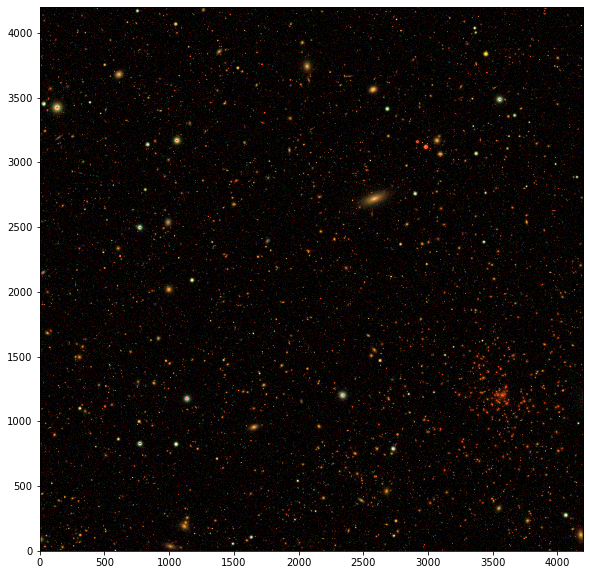

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [16]:
import lsst.afw.display.rgb as rgb

dataId = {'tract':tract_id, 'patch':patch_id}

bandpass_color_map = {'green':'r', 'red':'i', 'blue':'g'}

exposures = {}
for bandpass in bandpass_color_map.values():
    dataId['filter'] = bandpass
    exposures[bandpass] = butler.get('deepCoadd', dataId=dataId)

fig = plt.figure(figsize=(10,10))
rgb_im = rgb.makeRGB(*(exposures[bandpass_color_map[color]].getMaskedImage().getImage()
                       for color in ('red', 'green', 'blue')), Q=8, dataRange=1.0, 
                       xSize=None, ySize=None)

rgb.displayRGB(rgb_im)

## Selecting an Area on the Sky with a Sky Map

As a final example, we consider a third type of data that can be accessed via `Butler` called a `skyMap`. Sky maps allow you to look up information for a given `tract` and `patch`. You may notice from the below example that data set **types** tend to follow the naming convention of having a base name (e.g. `'deepCoadd'`) followed by a descriptor (e.g. `'_skyMap'`).

In [28]:
skymap = butler.get('deepCoadd_skyMap')
tract_info = skymap[0]
tract_info


TractInfo(id=0, ctrCoord=[6.123233995736766e-17, 0.0, -1.0])

In [29]:
patch_info = tract_info.getPatchInfo((1,1))
patch_info


PatchInfo(index=(1, 1), innerBBox=(minimum=(4000, 4000), maximum=(7999, 7999)), outerBBox=(minimum=(3900, 3900), maximum=(8099, 8099)))

In [30]:
tract_bbox = tract_info.getBBox()
tract_pix_corners = lsst.geom.Box2D(tract_bbox).getCorners()
print('Tract corners in pixels:\n', tract_pix_corners)

wcs = tract_info.getWcs()
tract_deg_corners = wcs.pixelToSky(tract_pix_corners)
tract_deg_corners = [[c.getRa().asDegrees(), c.getDec().asDegrees()] for c in tract_deg_corners]
print('\nTract corners in degrees:\n', tract_deg_corners)


Tract corners in pixels:
 [Point2D(-0.5, -0.5), Point2D(27999.5, -0.5), Point2D(27999.5, 27999.5), Point2D(-0.5, 27999.5)]

Tract corners in degrees:
 [[135.0, -88.90023048543114], [225.0020462778707, -88.90019121549136], [315.0, -88.9001519469551], [44.99795372212926, -88.90019121549136]]


In [31]:
#You can also go in reverse to find the tract, patch that contains a coordinate (320.8,-0.4)
coordList = [SpherePoint(Angle(np.radians(320.8)),Angle(np.radians(-0.4)))]
tractInfo = skymap.findClosestTractPatchList(coordList)
print(tractInfo[0][0])
print(tractInfo[0][1])

TractInfo(id=9443)
(PatchInfo(index=(6, 5), innerBBox=(minimum=(24000, 20000), maximum=(27999, 23999)), outerBBox=(minimum=(23900, 19900), maximum=(27999, 24099))),)
